## Historical Emissions Descriptive Data Analysis
This notebook explores the ClimateWatch Global Historical emissions data and makes comparisons to global warming trends explored in other parts of this project.

Data Source: 
ClimateWatchData - Global Historical Emissions
Source: https://www.climatewatchdata.org/ghg-emissions?end_year=2018&start_year=1990
About ClimateWatch: https://www.climatewatchdata.org/about/description

In [100]:
import csv
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from splot.mapping import vba_choropleth

mpl.rcParams.update(mpl.rcParamsDefault)

#Read in file, set first column (countries) as the index
fileIn = pd.read_csv('./data_files/ghg-emissions-pik.csv', index_col=0)
ems = pd.DataFrame(fileIn)

#remove false values
ems = ems.replace(to_replace = "FALSE", value=0)

## Total Greenhouse Gas Emissions - historical view all GHG emissions globally

,total
1850,929.98
1851,957.41
1852,987.86
1853,1021.53
1854,1082.67
...,...
2014,46744.23
2015,46759.58
2016,47075.88
2017,47712.86


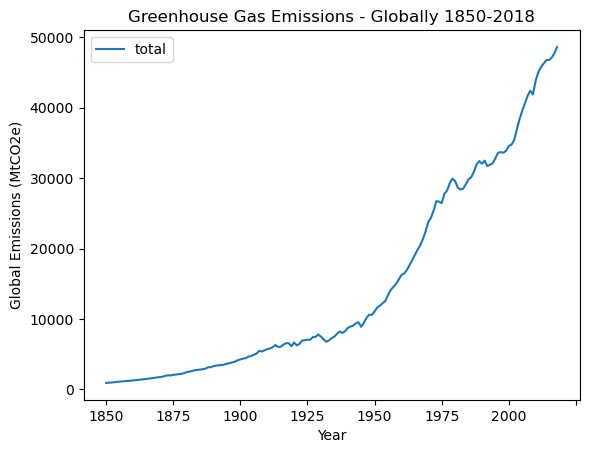

In [113]:
#add column for total emissions (by country) 1990 - 2018
ems['Country_Total'] = ems.sum(numeric_only=True, axis=1)
ems = ems.sort_values('Country_Total', axis=0)

#sum of each column
yT = pd.DataFrame(ems.sum())
yrTotals = yT.drop(labels=['Country_Total'], axis=0)

yrTotals.columns = ['total']
yrTotals.plot(title='Greenhouse Gas Emissions - Globally 1850-2018', xlabel='Year', ylabel='Global Emissions (MtCO2e)')

yrTotals

## GHG Emissions Inflection Point

In [109]:
#Prepare data - decade by decade view
decTotals = yrTotals.reset_index()
decTotals.columns = ['year', 'total']

#group every 10 years
decTotals = decTotals.groupby(decTotals.index//10).sum()

#add decade as index
decs = list(range(1850,2018,10))
decTotals.insert(0, "decade", decs, True)

pctChgD = decTotals["total"].pct_change()
decTotals.insert(2, "% change", pctChgD, True)

    decade      total  % change
0     1850   10863.37       NaN
1     1860   14865.92  0.368445
2     1870   20382.41  0.371083
3     1880   28101.65  0.378721
4     1890   36454.30  0.297230
5     1900   48937.91  0.342445
6     1910   61559.43  0.257909
7     1920   70129.44  0.139215
8     1930   75544.55  0.077216
9     1940   95349.47  0.262162
10    1950  132036.75  0.384766
11    1960  188692.83  0.429093
12    1970  268492.30  0.422907
13    1980  299360.00  0.114967
14    1990  327673.93  0.094582
15    2000  385909.51  0.177724
16    2010  417690.73  0.082354


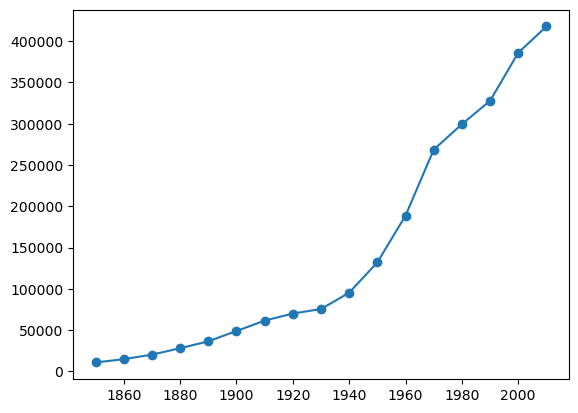

In [110]:
#plots to show general trend shift
print(decTotals)
plt.plot(decs, decTotals["total"], marker='o')

/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


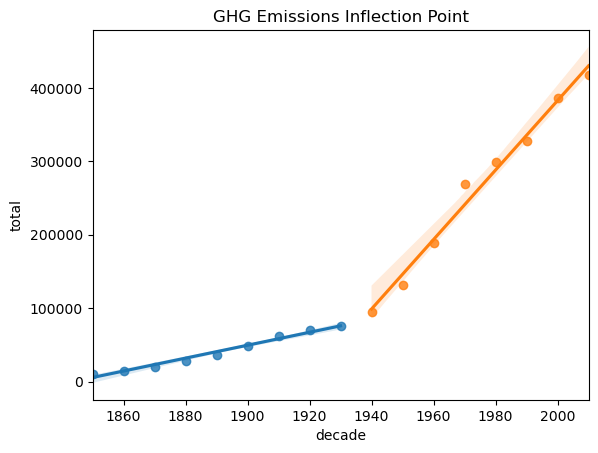

In [133]:
dec_1h = decTotals.iloc[:9,:]
dec_2h = decTotals.iloc[9:,:]

#make the break at 1960

slope, intercept, r_value, p_value, std_err = stats.linregress(dec_1h["decade"], dec_1h["total"])

ax1 = sns.regplot(dec_1h["decade"], dec_1h["total"], data = dec_1h, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax2 = sns.regplot(dec_2h["decade"], dec_2h["total"], data = dec_2h, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}).set(title='GHG Emissions Inflection Point')

# ax1.legend() no regression line equations available in seaborn
# ax2.legend()

plt.show()

## Total Greenhouse Gases - Map View

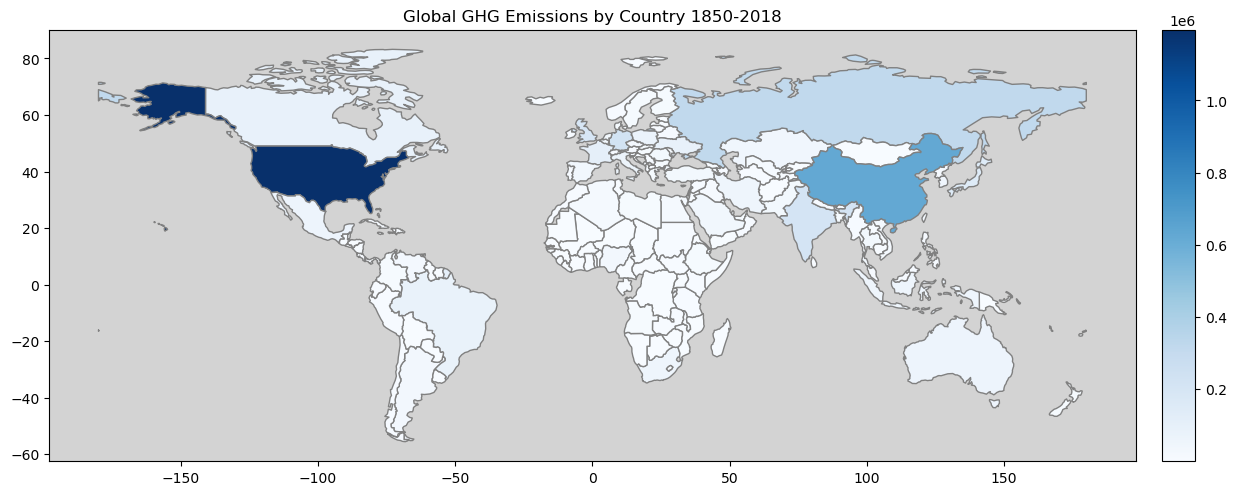

In [165]:
map_df = ems[["Country_Total"]]
map_df = map_df.reset_index()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.at[4,'name'] = "United States"
map_df['Country/Region'] = map_df['Country/Region'].replace(['Republic of Congo'], 'Dem. Rep. Congo')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Antarctica'], 'N/A')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Central African Republic'], 'Central African Rep.')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Taiwan, Republic of China'], 'Taiwan')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Czech Republic'], 'Czechia')
map_df['Country/Region'] = map_df['Country/Region'].replace(['South Sudan'], 'S. Sudan')
map_df['Country/Region'] = map_df['Country/Region'].replace(['Dominican Republic'], 'Dominican Rep.')





#world=world[(world.name !="Antarctica")]

match_world = []
mismatch_world = []
for x in list(map_df['Country/Region']):
    if x in list(world['name']):
        match_world.append(x)
    else: 
        mismatch_world.append(x)
        
world_df = pd.concat([world.set_index('name'),map_df.set_index('Country/Region')], axis=1, join='inner').reset_index()
world_df = world_df.rename(columns={"index":"country"})
#world = world[(world.Country_Total) & (world.index!="")] #only if specifying conditions for the map

#suggestions:
#drop antarctica 
#grey color as background 

fig,ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world_df.plot(column='Country_Total', ax=ax, legend=True, cax=cax, cmap='Blues', edgecolor='grey')
ax.set_title('Global GHG Emissions by Country 1850-2018')
ax.patch.set_facecolor('lightgrey')
fig.set_size_inches(15, 30)


## Total Greenhouse Gases - Top 10 Countries

In [11]:
#get the top 10 countries (total emissions over this time period)
emsTop10 = ems.nlargest(10,['Country_Total'])

<AxesSubplot:title={'center':'Historical Emissions by Country, 1850-2018'}, xlabel='Year', ylabel='Global Emissions (MtCO2e)'>

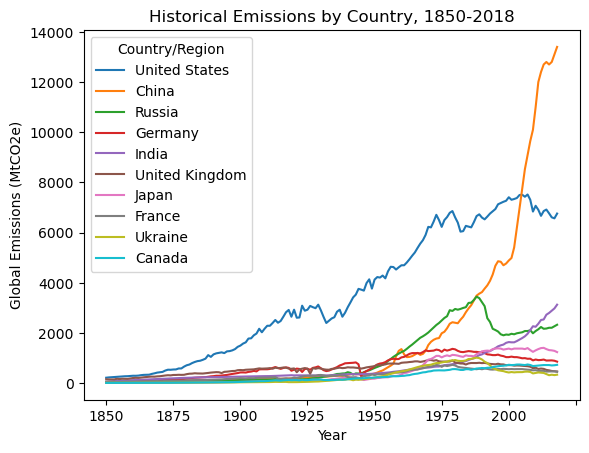

In [166]:
#plot totals over time
ems10T = emsTop10.T
ems10T.iloc[:-1].plot(title='Historical Emissions by Country, 1850-2018', xlabel='Year', ylabel='Global Emissions (MtCO2e)')#top10 = list(ems10T.columns)



In [13]:
#YoY % fluctuations
top10= list(ems10T.columns)
#drop the country totals, get percent change YoY for top 10
pct = ems10T.drop('Country_Total')
pctChg = pct.pct_change()

pctChgTop10 = pctChg[top10]
pctChgTop10.style.format("{:.2%}")

Country/Region,United States,China,Russia,Germany,India,United Kingdom,Japan,France,Ukraine,Canada
1850,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
1851,5.45%,6.91%,0.75%,4.17%,11.27%,-3.80%,0.70%,1.17%,0.63%,0.81%
1852,2.59%,6.47%,0.56%,5.20%,9.84%,0.00%,0.70%,3.92%,0.63%,0.81%
1853,3.78%,5.86%,0.55%,3.61%,8.82%,0.00%,0.69%,8.87%,0.63%,0.80%
1854,3.24%,5.53%,0.73%,7.52%,7.99%,15.79%,0.69%,8.55%,0.62%,1.59%
1855,4.71%,5.24%,0.55%,8.02%,7.28%,-4.55%,0.68%,7.88%,0.62%,0.78%
1856,2.25%,4.80%,0.54%,4.42%,7.10%,5.95%,1.36%,3.13%,0.61%,1.55%
1857,1.83%,4.58%,0.54%,3.93%,5.94%,-1.12%,0.67%,1.69%,0.61%,1.53%
1858,1.08%,4.21%,0.36%,4.80%,5.61%,-1.14%,1.33%,-0.50%,0.61%,0.75%
1859,3.56%,4.04%,0.36%,-1.67%,5.31%,9.20%,1.32%,1.33%,0.60%,2.24%


## Comparisons with Warming Data

In [170]:
#First exploring for data discrepancies between country names
#Identify any discrepancies as concatenate will just drop mismatches

#Load 
wdf = pd.read_csv('./data_files/country_t_incr_list.csv') #reminder: update to relative path in dir

debug = 1

#list of GHG countries
countries_GHG = ems.index.tolist()
countries_warm = wdf["Country"].tolist()

#lowercase
countries_GHG_lc = (map(lambda x: x.lower(), countries_GHG))

#formatting
#removing "-" from countries list (warming data) to compare to GHG data
rp = lambda x: x.replace(" ","-")
countries_GHG_lc = list(map(rp, countries_GHG_lc))

#address country discrepancies between data sets
rp_congo = lambda x: x.replace("democratic-republic-of-the-congo","congo-(democratic-republic-of-the)")
rp_hk = lambda y: y.replace('hong-kong,-special-administrative-region-of-china',"hong-kong")
rp_macau = lambda z: z.replace('macao,-special-administrative-region-of-china',"macau")
rp_tc = lambda t: t.replace('turks-and-caicos-islands','turks-and-caicas-islands')
rp_tw = lambda tw: tw.replace('taiwan,-republic-of-china','taiwan')
rp_mym = lambda m: m.replace('myanmar','burma')
countries_GHG_lc = list(map(rp_congo, countries_GHG_lc))
countries_GHG_lc = list(map(rp_hk, countries_GHG_lc))
countries_GHG_lc = list(map(rp_macau, countries_GHG_lc))
countries_GHG_lc = list(map(rp_tc, countries_GHG_lc))
countries_GHG_lc = list(map(rp_tw, countries_GHG_lc))
countries_GHG_lc = list(map(rp_mym, countries_GHG_lc))

match = []
mismatch = []

for ct in countries_GHG_lc:
    if ct in countries_warm:
        match.append(ct)
    else: 
        mismatch.append(ct)

In [191]:
#merge dataframes

world_bivar = world_df[["country", "geometry", "Country_Total"]]

#better way to do this?
world_bivar["country"] = world_bivar["country"].str.lower()
world_bivar["country"] = world_bivar["country"].map(rp)
wdf = wdf.rename(columns={'Country':'country'})

wb = world_bivar.merge(wdf, on='country')

print(wb.Country_Total.max(), wb.Country_Total.min(), wb.Warming_since_1960.max(), wb.Warming_since_1960.min())

world_bivar

1195872.0 119.66000000000003 3.64 0.65


/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,country,geometry,Country_Total
0,fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",274.54
1,tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",7581.26
2,canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",89322.80
3,united-states,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1195872.00
4,kazakhstan,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",45629.14
...,...,...,...
156,macedonia,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",1657.88
157,serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",8657.90
158,montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",690.12
159,trinidad-and-tobago,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",4674.54


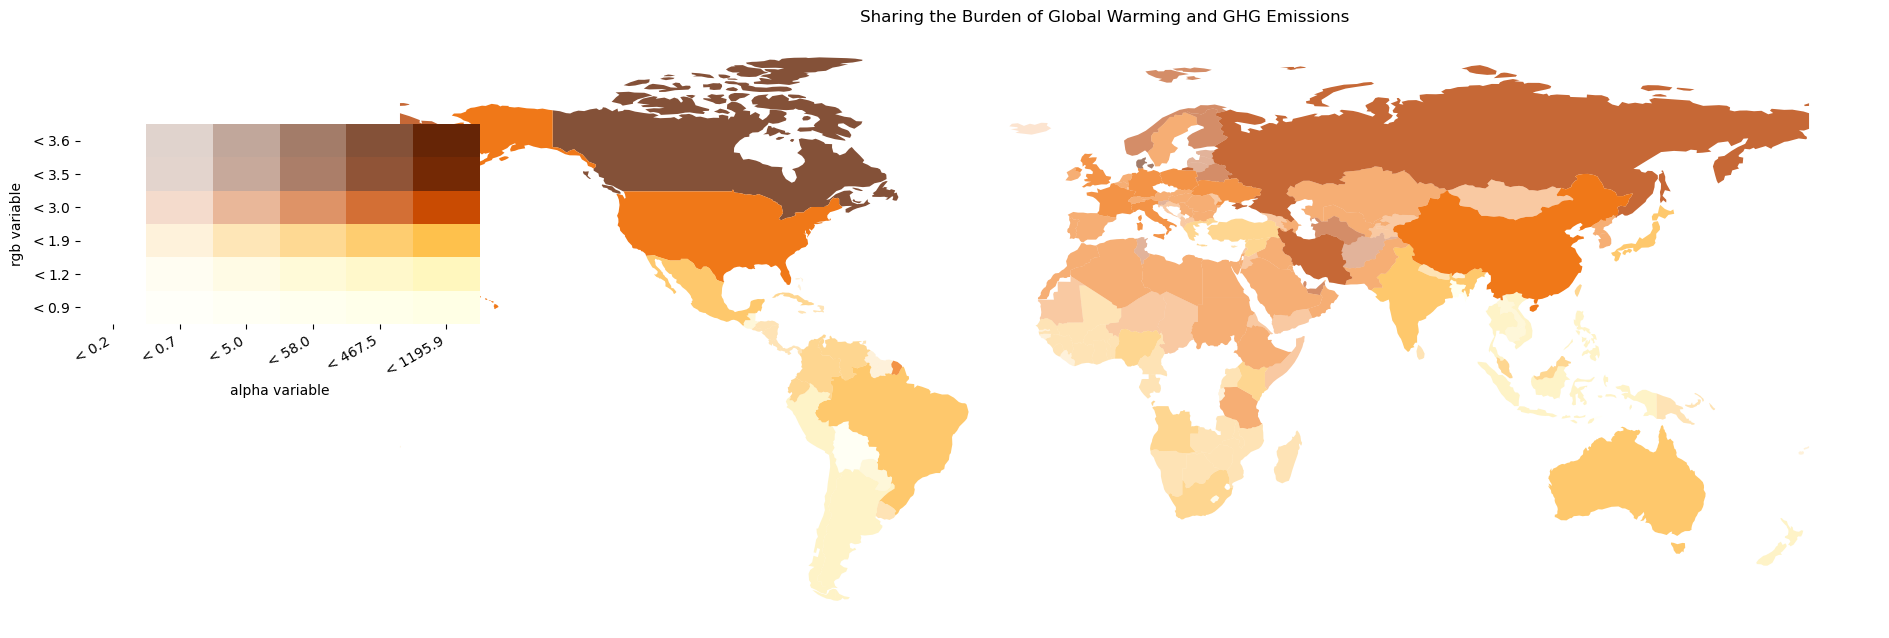

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [189]:
#plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
vba_choropleth(
    wb['Warming_since_1960'].values, 
    wb['Country_Total'].values, 
    wb, 
    rgb_mapclassify=dict(classifier='percentiles'),
    alpha_mapclassify=dict(classifier='percentiles'),
    cmap='YlOrBr',
    ax=ax,
    revert_alpha=False,
    legend=True)
ax.set_title('Sharing the Burden of Global Warming and GHG Emissions')
ax.patch.set_facecolor('lightgrey')
plt.show()
print(plt.style.available)

Remaining to do: 
    - Finish bivariate cloropleth
    - Fix slope
    - Remaining country fixes to get the most mapped possible